In [6]:
from games.kuhn.kuhn import KuhnPoker
from agents.counterfactualregret import CounterFactualRegret
from agents.mcts import MonteCarloTreeSearch
from agents.minimax import MiniMax
from collections import OrderedDict
from base.game import AlternatingGame, AgentID
from base.agent import Agent
import matplotlib.pyplot as plt
import numpy as np
from agents.agent_random import RandomAgent

In [7]:
game = KuhnPoker()

In [49]:
def play(agents: dict[AgentID, tuple[str,Agent]], verbose = True, n=10):
    categories = ["Ganados", "Empatados", "Perdidos"]
    results = {
        agent_id: [0, 0, 0] for agent_id in agents
    }
    rewards = { agent_id: [] for agent_id in agents }

    for i in range(n):
        # Se crea nueva instancia de juego para probar distintas posiciones
        game = KuhnPoker()
        game.reset()
        if verbose:
            print(f"Initial Agent: {game.agent_selection} ({agents[game.agent_selection][0]})")
        while not game.game_over():
            game.render()
            agent_id = game.agent_selection
            agent_name, agent = agents[agent_id]

            # sobrescribo el juego dado que se crean nuevas instancias
            agent.game = game
            action = agent.action()
            if verbose:
                print(f"Agent {agent_id} ({agent_name}) plays action {action}")
            game.step(action=action)
        game.render()
        if game.truncated():
            if verbose:
                print("Game was truncated")
        for agent_id, (agent_name, _) in agents.items():
            if verbose:
                print(f"Reward agent {agent_id} ({agent_name}): {game.reward(agent_id)}")

        winner = max(game.rewards, key=game.rewards.get)

        if verbose:
            if winner is None:
                print(f"Drawn game")
            else:
                print(f"The winner is: {winner} ({agents[winner][0]})")

        for agent_id in agents:
            rewards[agent_id].append(game.reward(agent_id))
            if winner is None:
                results[agent_id][1] += 1
            elif winner == agent_id:
                results[agent_id][0] += 1
            else:
                results[agent_id][2] += 1

    # Grafico rewards acumulados y cantidad de manos ganadas por cada agente
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax = axes[0]
    games = np.arange(1, n + 1)
    for agent_id, (agent_name, agent) in agents.items():
        ax.plot(games, np.cumsum(rewards[agent_id]), label=agent_name)
    ax.legend()
    ax.set_xlabel('Juegos')
    ax.set_ylabel('Rewards acumulados')

    ax = axes[1]
    x = np.arange(len(categories))
    bar_width = 0.35
    agent_ids = list(agents)

    ax.bar(x - bar_width/2, results[agent_ids[0]], bar_width, label=agents[agent_ids[0]][0])
    ax.bar(x + bar_width/2, results[agent_ids[1]], bar_width, label=agents[agent_ids[1]][0])

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Cantidad')
    ax.set_title(f"Comparación de resultados sobre {n} juegos")
    ax.legend()

    plt.show()

### Antes de ejecutar las pruebas en las siguientes celdas se verifica que CFR entrene bien comparando contra los resultados teóricos para kuhn poker.

In [9]:
agent_classes = [ CounterFactualRegret, CounterFactualRegret ]
my_agents = {}
game.reset()
for i, agent in enumerate(game.agents):
    my_agents[agent] = agent_classes[i](game=game, agent=agent)

In [10]:
for agent in game.agents:
    print('Training agent ' + agent)
    my_agents[agent].train(100000)
    print('Agent ' + agent + ' policies:')
    print(OrderedDict(map(lambda n: (n, my_agents[agent].node_dict[n].policy()), sorted(my_agents[agent].node_dict.keys()))))
    print('')

Training agent agent_0
Agent agent_0 policies:
OrderedDict([('0', array([0.67767469, 0.32232531])), ('0b', array([9.99969963e-01, 3.00372462e-05])), ('0p', array([0.66737061, 0.33262939])), ('0pb', array([9.99966752e-01, 3.32482476e-05])), ('1', array([9.99969899e-01, 3.01014419e-05])), ('1b', array([0.66805003, 0.33194997])), ('1p', array([9.99862222e-01, 1.37778177e-04])), ('1pb', array([0.34614528, 0.65385472])), ('2', array([0.0506776, 0.9493224])), ('2b', array([2.98347157e-05, 9.99970165e-01])), ('2p', array([2.98347157e-05, 9.99970165e-01])), ('2pb', array([4.44269293e-04, 9.99555731e-01]))])

Training agent agent_1
Agent agent_1 policies:
OrderedDict([('0', array([0.81284915, 0.18715085])), ('0b', array([9.99969901e-01, 3.00987238e-05])), ('0p', array([0.66426906, 0.33573094])), ('0pb', array([9.99972088e-01, 2.79121266e-05])), ('1', array([9.99770797e-01, 2.29202914e-04])), ('1b', array([0.65893324, 0.34106676])), ('1p', array([9.99837808e-01, 1.62192426e-04])), ('1pb', array(

In [11]:
print('Check learned policies against theoretical policies:')

Check learned policies against theoretical policies:


In [12]:
JX_b = my_agents[game.agents[0]].node_dict['0'].policy()[1]
print(f'Agent: 0 - Hand: J_ - History: [] - Probability of betting: {JX_b}')


Agent: 0 - Hand: J_ - History: [] - Probability of betting: 0.322325306847834


In [13]:
QX_pb_b = my_agents[game.agents[0]].node_dict['1pb'].policy()[1]
print(f'Agent: 0 - Hand: Q_ - History: pb - Probability of betting: {QX_pb_b} - Theoretic value: {JX_b+1/3} -  Difference: {abs(QX_pb_b - (JX_b+1/3))}')


Agent: 0 - Hand: Q_ - History: pb - Probability of betting: 0.6538547170123138 - Theoretic value: 0.6556586401811673 -  Difference: 0.0018039231688534718


In [14]:
KX_b = my_agents[game.agents[0]].node_dict['2'].policy()[1]
print(f'Agent: 0 - Hand: K_ - History: [] - Probability of betting: {KX_b} - Theoretic value: {3 * JX_b} -  Difference: {abs(KX_b - 3 * JX_b)}')


Agent: 0 - Hand: K_ - History: [] - Probability of betting: 0.9493224043202592 - Theoretic value: 0.966975920543502 -  Difference: 0.01765351622324285


In [15]:
XJ_p_b = my_agents[game.agents[0]].node_dict['0p'].policy()[1]
print(f'Agent: 0 - Hand: _J - History: p - Probability of betting: {XJ_p_b} - Theoretic value: {1/3} -  Difference: {abs(XJ_p_b - 1/3)}')

Agent: 0 - Hand: _J - History: p - Probability of betting: 0.3326293945516347 - Theoretic value: 0.3333333333333333 -  Difference: 0.0007039387816986098


In [16]:
XQ_b_b = my_agents[game.agents[0]].node_dict['1b'].policy()[1]
print(f'Agent: 0 - Hand: _Q - History: b - Probability of betting: {XQ_b_b} - Theoretic value: {1/3} -  Difference: {abs(XQ_b_b - 1/3)}')

Agent: 0 - Hand: _Q - History: b - Probability of betting: 0.33194997187749425 - Theoretic value: 0.3333333333333333 -  Difference: 0.0013833614558390606


### Pruebas

In [17]:
cfr = my_agents[game.agents[0]]

#### Random vs Minimax

Initial Agent: agent_0 (Random)
agent_0 K 
agent_1 Q 
Agent agent_0 (Random) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_1 (MiniMax) plays action 0
agent_0 K bp
agent_1 Q bp
Reward agent agent_0 (Random): 1
Reward agent agent_1 (MiniMax): -1
The winner is: agent_0 (Random)
Initial Agent: agent_0 (Random)
agent_0 J 
agent_1 Q 
Agent agent_0 (Random) plays action 0
agent_0 J p
agent_1 Q p
Agent agent_1 (MiniMax) plays action 1
agent_0 J pb
agent_1 Q pb
Agent agent_0 (Random) plays action 0
agent_0 J pbp
agent_1 Q pbp
Reward agent agent_0 (Random): -1
Reward agent agent_1 (MiniMax): 1
The winner is: agent_1 (MiniMax)
Initial Agent: agent_0 (Random)
agent_0 K 
agent_1 Q 
Agent agent_0 (Random) plays action 0
agent_0 K p
agent_1 Q p
Agent agent_1 (MiniMax) plays action 0
agent_0 K pp
agent_1 Q pp
Reward agent agent_0 (Random): 1
Reward agent agent_1 (MiniMax): -1
The winner is: agent_0 (Random)
Initial Agent: agent_1 (MiniMax)
agent_0 Q 
agent_1 J 
Agent agent_1 (MiniMax) plays actio

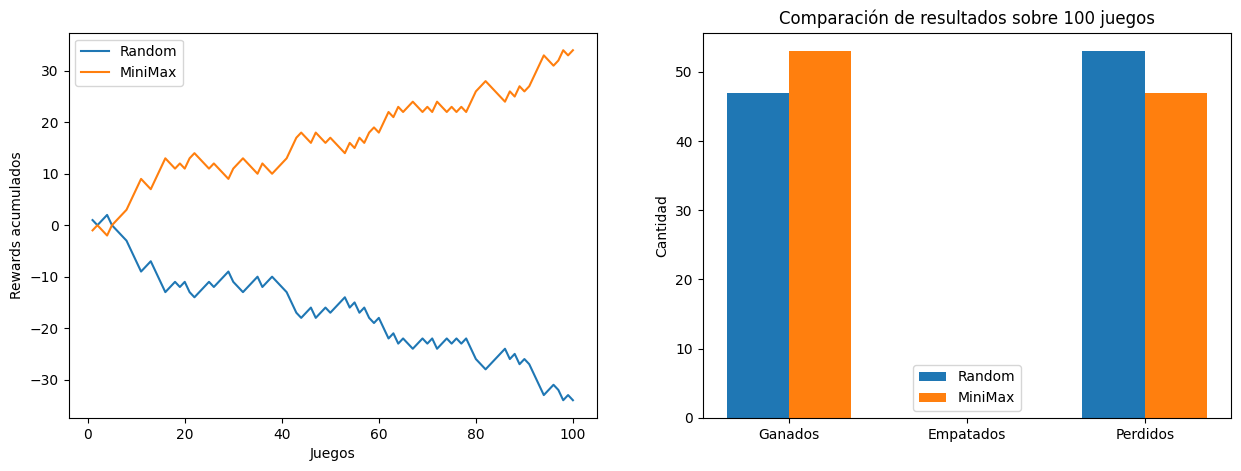

In [18]:
play({
    game.agents[0]: ("Random", RandomAgent(game=game, agent=game.agents[0])),
    game.agents[1]: ("MiniMax", MiniMax(game=game, agent=game.agents[1])),
}, n=100)

#### Random vs MCTS

Initial Agent: agent_0 (Random)
agent_0 J 
agent_1 K 
Agent agent_0 (Random) plays action 1
agent_0 J b
agent_1 K b
Agent agent_1 (MCTS) plays action 1
agent_0 J bb
agent_1 K bb
Reward agent agent_0 (Random): -2
Reward agent agent_1 (MCTS): 2
The winner is: agent_1 (MCTS)
Initial Agent: agent_1 (MCTS)
agent_0 K 
agent_1 Q 
Agent agent_1 (MCTS) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_0 (Random) plays action 0
agent_0 K bp
agent_1 Q bp
Reward agent agent_0 (Random): -1
Reward agent agent_1 (MCTS): 1
The winner is: agent_1 (MCTS)
Initial Agent: agent_1 (MCTS)
agent_0 J 
agent_1 K 
Agent agent_1 (MCTS) plays action 1
agent_0 J b
agent_1 K b
Agent agent_0 (Random) plays action 1
agent_0 J bb
agent_1 K bb
Reward agent agent_0 (Random): -2
Reward agent agent_1 (MCTS): 2
The winner is: agent_1 (MCTS)
Initial Agent: agent_0 (Random)
agent_0 Q 
agent_1 K 
Agent agent_0 (Random) plays action 1
agent_0 Q b
agent_1 K b
Agent agent_1 (MCTS) plays action 1
agent_0 Q bb
agent_1 K bb
Reward 

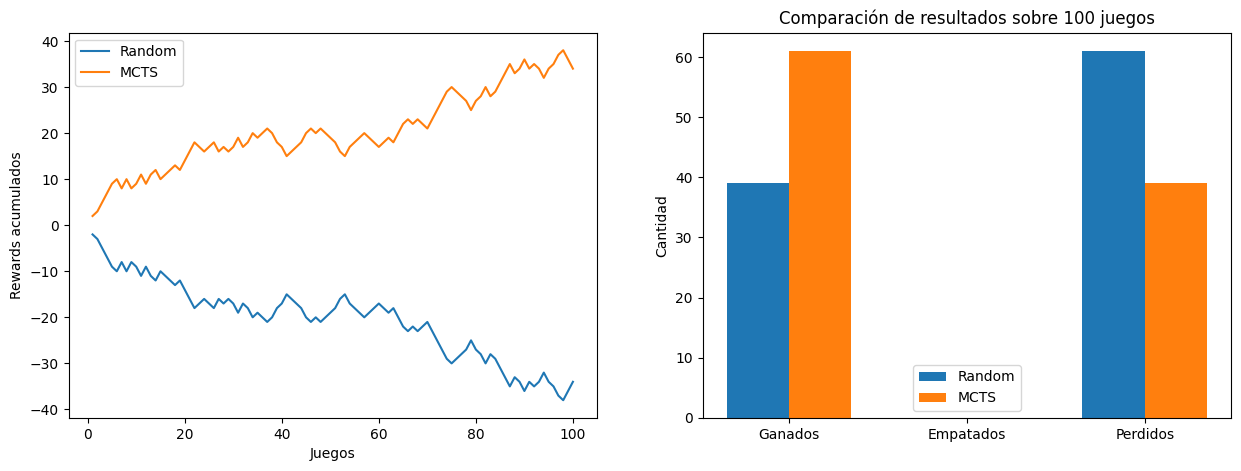

In [19]:
play({
    game.agents[0]: ("Random", RandomAgent(game=game, agent=game.agents[0])),
    game.agents[1]: ("MCTS", MonteCarloTreeSearch(game=game, agent=game.agents[1], max_depth=0)),
}, n=100)

#### Random vs CFR

Initial Agent: agent_0 (CFR)
agent_0 K 
agent_1 Q 
Agent agent_0 (CFR) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_1 (Random) plays action 1
agent_0 K bb
agent_1 Q bb
Reward agent agent_0 (CFR): 2
Reward agent agent_1 (Random): -2
The winner is: agent_0 (CFR)
Initial Agent: agent_1 (Random)
agent_0 K 
agent_1 Q 
Agent agent_1 (Random) plays action 0
agent_0 K p
agent_1 Q p
Agent agent_0 (CFR) plays action 1
agent_0 K pb
agent_1 Q pb
Agent agent_1 (Random) plays action 1
agent_0 K pbb
agent_1 Q pbb
Reward agent agent_0 (CFR): 2
Reward agent agent_1 (Random): -2
The winner is: agent_0 (CFR)
Initial Agent: agent_1 (Random)
agent_0 J 
agent_1 Q 
Agent agent_1 (Random) plays action 0
agent_0 J p
agent_1 Q p
Agent agent_0 (CFR) plays action 0
agent_0 J pp
agent_1 Q pp
Reward agent agent_0 (CFR): -1
Reward agent agent_1 (Random): 1
The winner is: agent_1 (Random)
Initial Agent: agent_1 (Random)
agent_0 Q 
agent_1 J 
Agent agent_1 (Random) plays action 0
agent_0 Q p
agent_1 J p
Agent ag

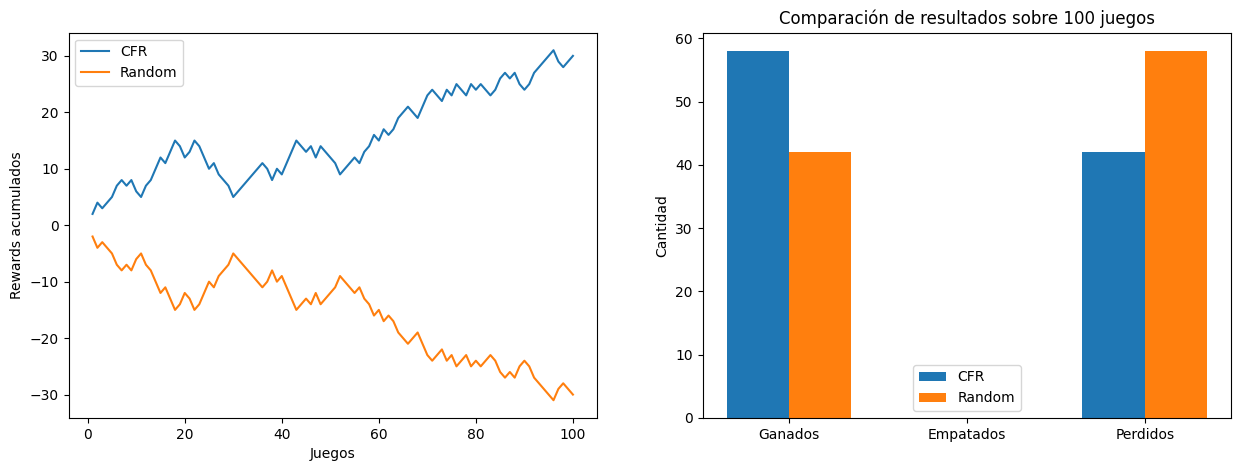

In [20]:
cfr.agent = game.agents[0]
play({
    game.agents[0]: ("CFR", cfr),
    game.agents[1]: ("Random", RandomAgent(game=game, agent=game.agents[1])),
}, n=100)

#### CFR vs Minimax

Initial Agent: agent_0 (CFR)
agent_0 K 
agent_1 Q 
Agent agent_0 (CFR) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_1 (Minimax) plays action 0
agent_0 K bp
agent_1 Q bp
Reward agent agent_0 (CFR): 1
Reward agent agent_1 (Minimax): -1
The winner is: agent_0 (CFR)
Initial Agent: agent_1 (Minimax)
agent_0 K 
agent_1 Q 
Agent agent_1 (Minimax) plays action 0
agent_0 K p
agent_1 Q p
Agent agent_0 (CFR) plays action 1
agent_0 K pb
agent_1 Q pb
Agent agent_1 (Minimax) plays action 0
agent_0 K pbp
agent_1 Q pbp
Reward agent agent_0 (CFR): 1
Reward agent agent_1 (Minimax): -1
The winner is: agent_0 (CFR)
Initial Agent: agent_1 (Minimax)
agent_0 K 
agent_1 J 
Agent agent_1 (Minimax) plays action 0
agent_0 K p
agent_1 J p
Agent agent_0 (CFR) plays action 1
agent_0 K pb
agent_1 J pb
Agent agent_1 (Minimax) plays action 0
agent_0 K pbp
agent_1 J pbp
Reward agent agent_0 (CFR): 1
Reward agent agent_1 (Minimax): -1
The winner is: agent_0 (CFR)
Initial Agent: agent_0 (CFR)
agent_0 J 
agent_1 Q 


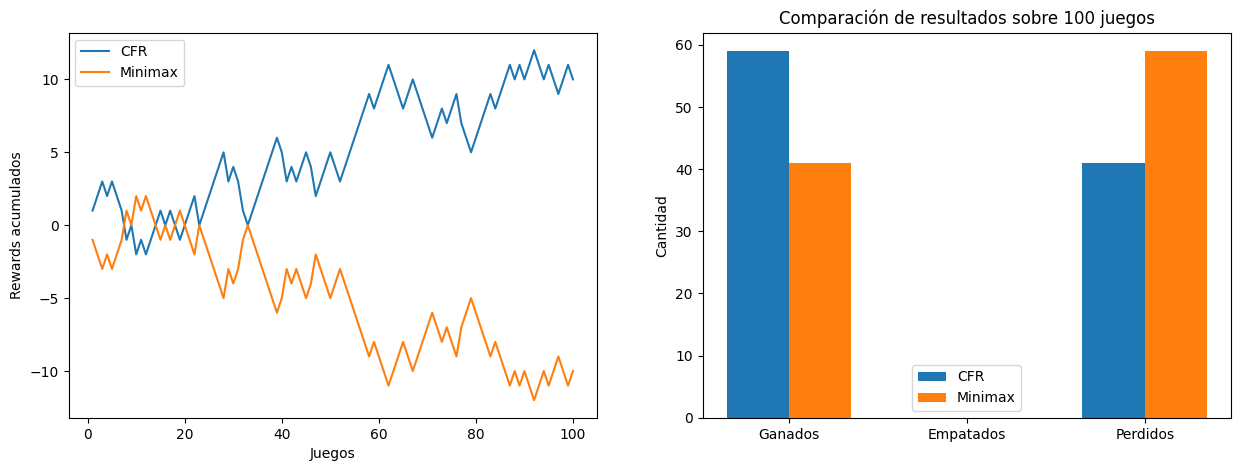

In [43]:
cfr.agent = game.agents[0]
play({
    game.agents[0]: ("CFR", cfr),
    game.agents[1]: ("Minimax", MiniMax(game=game, agent=game.agents[1])),
    
}, n=100)

#### CFR vs MCTS

Initial Agent: agent_0 (CFR)
agent_0 Q 
agent_1 K 
Agent agent_0 (CFR) plays action 0
agent_0 Q p
agent_1 K p
Agent agent_1 (MCTS) plays action 1
agent_0 Q pb
agent_1 K pb
Agent agent_0 (CFR) plays action 1
agent_0 Q pbb
agent_1 K pbb
Reward agent agent_0 (CFR): -2
Reward agent agent_1 (MCTS): 2
The winner is: agent_1 (MCTS)
Initial Agent: agent_1 (MCTS)
agent_0 Q 
agent_1 K 
Agent agent_1 (MCTS) plays action 1
agent_0 Q b
agent_1 K b
Agent agent_0 (CFR) plays action 0
agent_0 Q bp
agent_1 K bp
Reward agent agent_0 (CFR): -1
Reward agent agent_1 (MCTS): 1
The winner is: agent_1 (MCTS)
Initial Agent: agent_1 (MCTS)
agent_0 K 
agent_1 Q 
Agent agent_1 (MCTS) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_0 (CFR) plays action 1
agent_0 K bb
agent_1 Q bb
Reward agent agent_0 (CFR): 2
Reward agent agent_1 (MCTS): -2
The winner is: agent_0 (CFR)
Initial Agent: agent_1 (MCTS)
agent_0 Q 
agent_1 J 
Agent agent_1 (MCTS) plays action 1
agent_0 Q b
agent_1 J b
Agent agent_0 (CFR) plays action

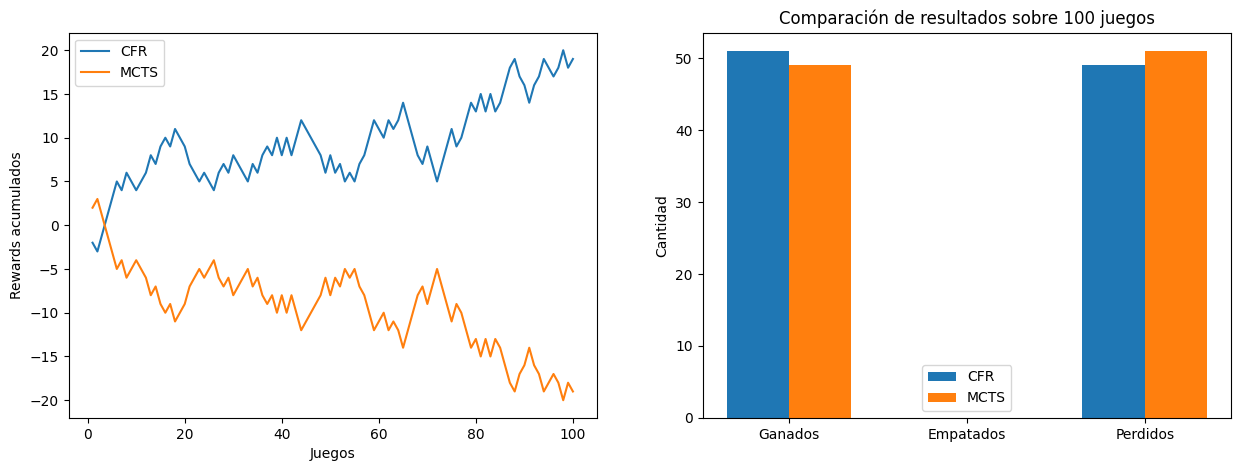

In [22]:
cfr.agent = game.agents[0]
play({
    game.agents[0]: ("CFR", cfr),
    game.agents[1]: ("MCTS", MonteCarloTreeSearch(game=game, agent=game.agents[1], max_depth=0)),
}, n=100)

#### MCTS vs Minimax

Initial Agent: agent_0 (MCTS)
agent_0 K 
agent_1 Q 
Agent agent_0 (MCTS) plays action 1
agent_0 K b
agent_1 Q b
Agent agent_1 (Minimax) plays action 0
agent_0 K bp
agent_1 Q bp
Reward agent agent_0 (MCTS): 1
Reward agent agent_1 (Minimax): -1
The winner is: agent_0 (MCTS)
Initial Agent: agent_1 (Minimax)
agent_0 K 
agent_1 J 
Agent agent_1 (Minimax) plays action 0
agent_0 K p
agent_1 J p
Agent agent_0 (MCTS) plays action 1
agent_0 K pb
agent_1 J pb
Agent agent_1 (Minimax) plays action 0
agent_0 K pbp
agent_1 J pbp
Reward agent agent_0 (MCTS): 1
Reward agent agent_1 (Minimax): -1
The winner is: agent_0 (MCTS)
Initial Agent: agent_1 (Minimax)
agent_0 Q 
agent_1 K 
Agent agent_1 (Minimax) plays action 1
agent_0 Q b
agent_1 K b
Agent agent_0 (MCTS) plays action 0
agent_0 Q bp
agent_1 K bp
Reward agent agent_0 (MCTS): -1
Reward agent agent_1 (Minimax): 1
The winner is: agent_1 (Minimax)
Initial Agent: agent_0 (MCTS)
agent_0 Q 
agent_1 K 
Agent agent_0 (MCTS) plays action 1
agent_0 Q b
agent

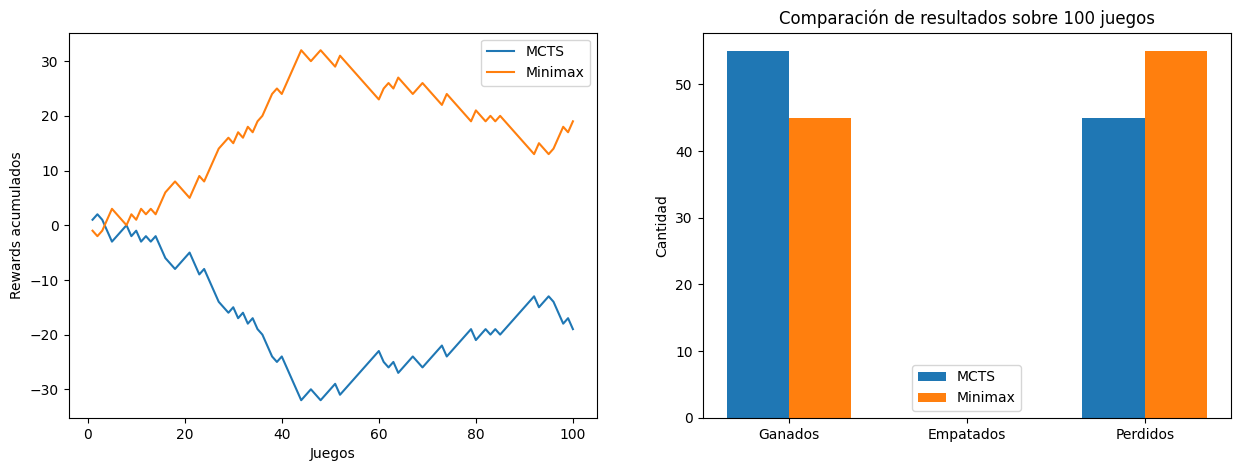

In [45]:
play({
    game.agents[0]: ("MCTS", MonteCarloTreeSearch(game=game, agent=game.agents[0], simulations=200, rollouts=20, max_depth=0)),
    game.agents[1]: ("Minimax", MiniMax(game=game, agent=game.agents[1])),
}, n=100)